## 데이터 사이언스 입문반 오프라인 COMPETITION
## 4조
## 2019년 9월 28일

-

## 1. 라이브러리 및 데이터
## Library & Data

In [49]:
# 라이브러리
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.combine import *
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from os.path import join
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, reset_parameter
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
#데이터 불러오기 
tst_path = join('data','test_final.csv')
train_path = join('data', 'train_final.csv')
test = pd.read_csv(tst_path)
train = pd.read_csv(train_path)

## 2. 데이터 전처리 & 탐색적 자료분석
## Data Cleansing & Pre-Processing & Exploratory Data Analysis

In [6]:
# id 와 login 을 먼저 떼어내고 전처리 실행
train_id = train['person_id']
test_id = test['person_id']

train.drop('person_id',axis =1 ,inplace = True)
test.drop('person_id', axis = 1, inplace = True)

login = train['login']

# train, test 합쳐서 전처리
df = pd.concat([train,test], axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [8]:
# na 값 확인 및 처리 
# (na값 / 전체길이) * 100 
na_value = (df.isnull().sum()/len(df)) * 100
na_value = na_value.drop(na_value[na_value ==0].index).sort_values(ascending=True) # na 가 없는 column은 제외하고 오름차순 출력
# print(na_value)

In [9]:
# 남성과 여성의 비율이 비슷하므로 na => unknown 으로 처리한다
df['Sex'].fillna('Unknown', inplace=True)

### 대부분 로그인을 안한다, 그리고 제출 경험도 없다
### 지난 1달동안 로그인 기록이 없으면 0으로 대체
### 로그인을 하지 않고 제출할 수 없으므로 sub_size가 0이 아닌 past_login_total의 na값은 평균으로 대체

In [18]:

df['past_1_month_login'].fillna(0,inplace =True)
df['past_1_week_login'].fillna(0, inplace=True)
df.set_index(np.arange(len(df)),inplace=True)

idx=[]
idx2=[]
for i,row in enumerate(df['past_login_total']):
    if df['sub_size'][i]>0.0:
        if pd.isna(row) == True:
            idx.append(i)
    elif df['sub_size'][i]==0.0:
        if pd.isna(row) ==True:
            idx2.append(i)
df.loc[idx,'past_login_total'] = 8.0
df.loc[idx2, 'past_login_total'] = 0.0

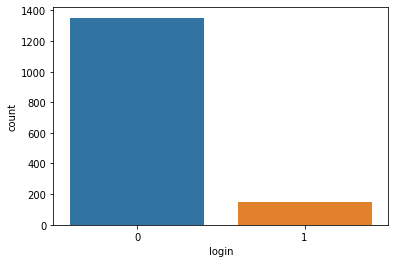

In [19]:
# Y 시각화로 확인 
sns.countplot(x = login, data=train)
# 대부분 0 의값을 가짐, 데이터가 한 쪽으로 치우쳐져 불균형함

col Sex
------------------------------------------------------------


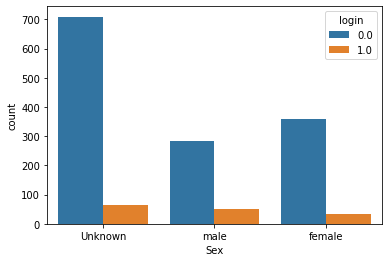

col email_type
------------------------------------------------------------


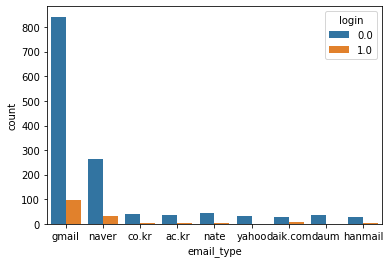

In [20]:
# X 시각화로 확인
# X 역시 불균형
for col in df.columns:
    if col in ['Sex', 'email_type' ]:
        
        print('col', col)
        print('-'*60)

        sns.countplot(x = col, hue = 'login', data= df)
    plt.show()

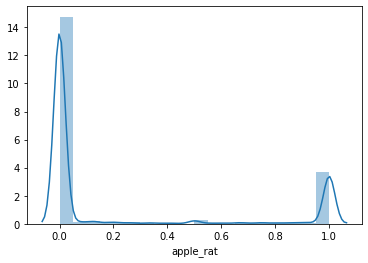

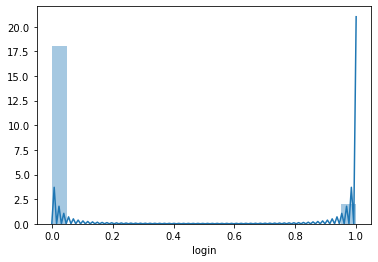

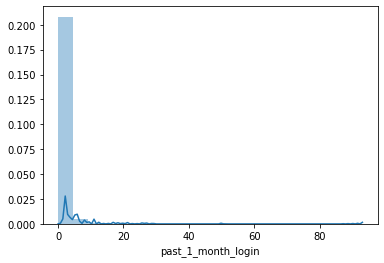

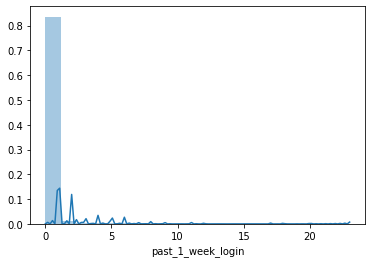

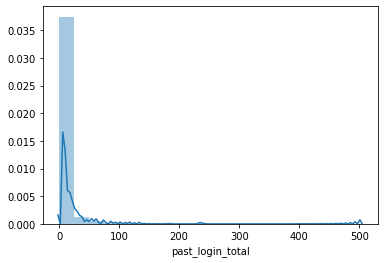

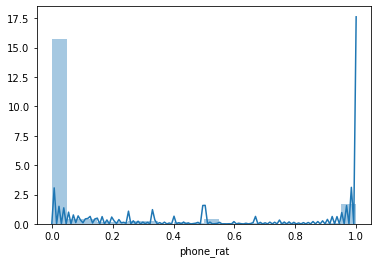

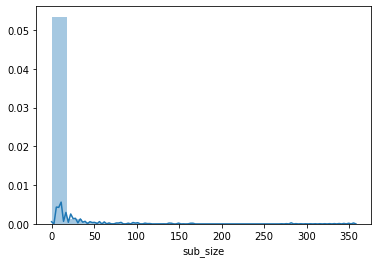

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6721: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6722: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

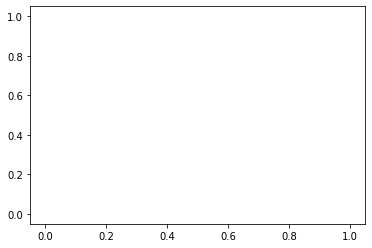

In [21]:
for col in df.columns:
    if col in ['Sex', 'email_type' ]:
        continue
    
    sns.distplot(df[col], bins =20)
    plt.show()

## 3. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling

In [22]:
# computer 로 접속한 비율, apple 이 아닌기기로 접속한 비율
df['com_rat'] = np.nan
temp = []
for i,_ in enumerate(df['com_rat']):
    if df['phone_rat'][i] != 1.0 and df['phone_rat'][i] !=0.0:
        temp.append(i)
df.loc[temp,'com_rat'] = 1 - df.loc[temp,'phone_rat'] 

temp = []
for i,_ in enumerate(df['com_rat']):
    if df['phone_rat'][i] ==0.0:
        temp.append(i)
df.loc[temp,'com_rat'] = 1.000000    

temp = []
for i,_ in enumerate(df['com_rat']):
    if df['phone_rat'][i] ==1.0:
        temp.append(i)
df.loc[temp,'com_rat'] = 0.000000   

In [23]:
df['non_apple_rat'] = 1 - df.loc[df['apple_rat'] > 0 ,'apple_rat']
df['non_apple_rat'].fillna(1.000000, inplace=True)

In [24]:
# user label 달아주기
df['user_label'] = None
index_1 = df.loc[df['past_login_total'] - df['past_1_month_login']>0].index # 1달 이전부터 활동 유저 index
index_2 = df.loc[df['past_login_total']==0].index # 한 번도 로그인 경험이 없는 유저 index
a = df.drop(index_1,axis=0)
a = a.drop(index_2, axis=0)
index_3 = a.index # 로그인 시작 1달이내의 유저
# user label 달아주기
df['user_label'][index_1]=df['user_label'][index_1].map(lambda x :'old')
df['user_label'][index_2]=df['user_label'][index_2].map(lambda x :'never')
df['user_label'][index_3]=df['user_label'][index_3].map(lambda x : 'new')
# 전체 로그인 수에서 1주일 이내에 로그인 수가 차지하는 비중 => 최근에 로그인을 계속 할 수록 로그인 할 확률이 높다고 생각함
df['past_1_week_rat'] = round(df['past_1_week_login']/df['past_login_total'],7)
df['past_1_week_rat'].fillna(0.000000,inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


### MinMaxScaler 로 scale 조정(딥러닝 모델 써보려고 했으나 안씀)

In [26]:
login = df['login']
# 범주형 변수 아닌 것을 골라내기
subset_col = [col for col in df.columns if df[col].dtype != 'object']
subset = df[subset_col]
# MinMaxScaler
mmx = MinMaxScaler()
mmx.fit(subset)
subset = mmx.transform(np.array(subset))
subset = pd.DataFrame(subset, columns=subset_col)
str_col = [col for col in df.columns if df[col].dtype == 'object']
subset2 = df[str_col]
data = pd.concat([subset, subset2], axis=1)
data.drop('login', axis=1, inplace=True)
#data = pd.get_dummies(data3)

In [64]:
train = data[:trn.shape[0]]
test = data[trn.shape[0]:]
login.dropna(inplace=True)
test.set_index(np.arange(len(test)),inplace=True)

In [65]:
# one-hot-encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

### login 비율이 거의 9:1 이기때문에 0의 비율을 줄여서 비중을 낮춘다
### 과거에 login경험이 1회도 없거나, 1회인 사람 중에 없앰

In [30]:
index = []
index2 = []
for i in range(len(train)):
    if df['login'][i] == 0.0 and df['past_login_total'][i] ==0.0:
        index.append(i)
    elif df['login'][i] ==0.0 and df['past_login_total'][i] ==1.0:
        index2.append(i)
    
# print(len(index))
# print(len(index2))
# 무작위로 삭제
# 0회에서 50명, 1회에서 220명
r = np.random.choice(index, 50, replace= False)
r2 = np.random.choice(index2, 220, replace=False)
# print('index', r)
# print(len(r))
train.drop(r, axis=0,inplace=True)
train.drop(r2, axis=0,inplace=True)
train.set_index(np.arange(len(train)),inplace=True)

In [31]:
'''
r 
 [ 544 1165 1019 1095  861  782  200  585 1290 1338  505   12  762 1274
   98 1103  646 1005 1417  735 1481   87  781 1370  419 1207 1465 1032
  335  963  400  132  867  550  935  681 1431 1260  281 1266  954 1188
  882  483  381  237  966  152   40 1183]
r2 
 [ 883  959 1462  437 1366  943 1023 1239  919 1391 1473 1152  224  148
  394 1264  180   60  444  817  885 1091   74 1448  103   92  352 1168
  904   64 1236  687 1314  683  390 1210  273 1229 1070 1007 1206  621
  960  738 1068 1139  517  852 1384  974  426  368  955  489 1163 1416
 1303  783  770 1115  924  936  983 1291  793  525 1063  234  796   16
  288 1293  918  578 1469  351  675 1234 1164  992 1361  541  324  577
 1439  197  800  806  268  978  482  710   59 1394  330 1144  321  274
  797 1076 1056  157  940  906  714  700  838  931  914  470  795 1389
   57   55 1247 1278  406  509  982  786  601  609  371  691  238 1310
   65   47 1241  243  647  706  556  752 1499  794  619 1485  211  433
   93  562  307 1177  616  367 1075  430  160 1429  373  232 1219 1074
  387 1073 1106  964  858 1150  666 1258 1482  878  779  802  893  523
 1344  739  388 1017  242  635 1132 1230  643  818   91 1248 1055 1438
  256 1421 1036  474  661  314  171 1079  653  705 1058 1250   68  708
   31  493 1382 1398  731  208 1061 1309 1452   15 1244  292   62  164
  401  518 1130  834 1289  327  139 1363  359  734]
'''
# 위의 값이 제출할 때 썼던 random 추출값
# np.random.seed(1) 를 쓰면 랜덤값 고정

'\nr \n [ 544 1165 1019 1095  861  782  200  585 1290 1338  505   12  762 1274\n   98 1103  646 1005 1417  735 1481   87  781 1370  419 1207 1465 1032\n  335  963  400  132  867  550  935  681 1431 1260  281 1266  954 1188\n  882  483  381  237  966  152   40 1183]\nr2 \n [ 883  959 1462  437 1366  943 1023 1239  919 1391 1473 1152  224  148\n  394 1264  180   60  444  817  885 1091   74 1448  103   92  352 1168\n  904   64 1236  687 1314  683  390 1210  273 1229 1070 1007 1206  621\n  960  738 1068 1139  517  852 1384  974  426  368  955  489 1163 1416\n 1303  783  770 1115  924  936  983 1291  793  525 1063  234  796   16\n  288 1293  918  578 1469  351  675 1234 1164  992 1361  541  324  577\n 1439  197  800  806  268  978  482  710   59 1394  330 1144  321  274\n  797 1076 1056  157  940  906  714  700  838  931  914  470  795 1389\n   57   55 1247 1278  406  509  982  786  601  609  371  691  238 1310\n   65   47 1241  243  647  706  556  752 1499  794  619 1485  211  433\n   93  

In [32]:
# login 에서도 r,r2 인덱스를 삭제한다
login.drop(r, axis=0, inplace=True)
login.drop(r2, axis=0, inplace=True)
login.index =np.arange(len(login))

# ENN
ENN(Edited Nearest Neighbours) 방법은 다수 클래스 데이터 중 가장 가까운 k(n_neighbors)개의 데이터가 모두(kind_sel="all") 또는 다수(kind_sel="mode") 
다수 클래스가 아니면 삭제하는 방법이다. 소수 클래스 주변의 다수 클래스 데이터는 사라진다.

# SMOTE
생성된 데이터를 무조건 소수 클래스라고 하지 않고 분류 모형에 따라 분류한다.

# SMOTEENN 
위의 두 가지를 합친 것 (오버 샘플링과 언더 샘플링을 합침)

In [33]:
# 불균형 데이터셋의 균형을 맞춰주는 알고리즘, SMOTEENN을 사용
sm = SMOTEENN(random_state=0)

x_sam, y_sam = sm.fit_sample(train, login)
x_train =pd.DataFrame(x_sam, columns=train.columns)

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [34]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_sam)
print('rf_score',rf.score(x_train, y_sam))

rf_score 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train, y_sam)
print('xgb_score', xgb.score(x_train, y_sam))

xgb_score 0.9739478957915831


In [36]:
lgr = LogisticRegression(random_state=42)
lgr.fit(x_train,y_sam)
print('lbr_score', lgr.score(x_train,y_sam))

lbr_score 0.8343353373413493


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [37]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train,y_sam)
print('lgbm_score', lgbm.score(x_train,y_sam))

lgbm_score 1.0


In [38]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(x_train,y_sam)
print('gb_score', gb.score(x_train,y_sam))

gb_score 0.9839679358717435


### RandomForest, XGBoost, LGBM 으로 실험 후  LGBM 선택

In [40]:
# 파라미터 수정

In [41]:
x_train['login'] = y_sam
print(x_train.loc[x_train['login'] ==1.0].shape)
print(x_train.loc[x_train['login'] ==0.0].shape)
print(x_train.loc[x_train['login'] ==1.0].shape[0]/x_train.shape[0] * 100)

(748, 25)
(749, 25)
49.96659986639946


In [42]:
print(746*0.3)
print(802*0.3)

223.79999999999998
240.6


In [43]:
copy = x_train.copy()
# train, valid set으로 나눈다 / 7:3 의 비율
# val set 생성
x_val_index = np.random.choice(x_train.loc[x_train['login'] ==1.0].index, 224, replace = False)
x_val_index2 =  np.random.choice(x_train.loc[x_train['login'] ==0.0].index, 240, replace = False)
subset_val_1 = x_train.loc[x_val_index]
subset_val_2 = x_train.loc[x_val_index2]
x_val = pd.concat([subset_val_1, subset_val_2], axis=0)
y_val = x_val['login']
del x_val['login']

In [44]:
x_train.drop(x_val_index, axis=0, inplace = True)
x_train.drop(x_val_index2, axis=0, inplace = True)
y_sam = pd.Series(y_sam)
y_sam.drop(x_val_index, axis=0, inplace = True)
y_sam.drop(x_val_index2, axis=0, inplace = True)
x_train.set_index(np.arange(len(x_train)),inplace=True)
y_sam.index = np.arange(len(y_sam))
del x_train['login']

In [45]:
X_train = copy.drop('login',axis=1)
y_train = copy.login

In [46]:
# Kaggle 에서 parameter 수정하는 법 참고함
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val,y_val)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [47]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [50]:
n_HP_points_to_test = 100

clf = LGBMClassifier(max_depth=-1, random_state=42, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=42,
    verbose=True)

In [51]:
gs.fit(x_train, y_sam, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[11]	valid's auc: 0.907347

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[20]	valid's auc: 0.907347
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[11]	valid's auc: 0.911561
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't impr

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   19.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[300]	valid's auc: 0.990355
[400]	valid's auc: 0.99176
[500]	valid's auc: 0.992485
Early stopping, best iteration is:
[513]	valid's auc: 0.99269
Best score reached: 0.9875793085011804 with params: {'colsample_bytree': 0.9979821022443432, 'min_child_samples': 122, 'min_child_weight': 1, 'num_leaves': 42, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.3928678658637055} 


In [52]:
opt_parameters = {'colsample_bytree': 0.9979821022443432, 'min_child_samples': 122, 'min_child_weight': 1, 'num_leaves': 42, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.3928678658637055}

In [53]:
clf_sw = LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9979821022443432, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=122, min_child_weight=1, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=42, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0, silent=True,
               subsample=0.3928678658637055, subsample_for_bin=200000,
               subsample_freq=0)

In [54]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[4,6,8,10,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [55]:
gs_sample_weight.fit(copy.drop('login',axis=1), copy.login, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.992364
[200]	valid's auc: 0.997675
[300]	valid's auc: 0.998605

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[400]	valid's auc: 0.999479
Early stopping, best iteration is:
[423]	valid's auc: 0.999535
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.989249
[200]	valid's auc: 0.994922
Early stopping, best iteration is:
[220]	valid's auc: 0.995796
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.991536
[200]	valid's auc: 0.997991
[300]	valid's auc: 0.999386
Early stopping, best iteration is:
[356]	valid's auc: 0.999721
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.992011
[200]	valid's auc: 0.997842
[300]	valid's auc: 0.999089
[400]	valid's auc: 0.999554
[500]	valid's auc: 0.999665
Early stopping, best iteration is:
[508]	valid's auc: 0.99974
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.988904
[200]	valid's auc: 0.995759
[300]	valid's auc: 0.997321
[400]	valid's auc: 0.997954
Early stopping, best iteration is:
[416]	valid's auc: 0.99801
Training until val

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   15.3s finished



[200]	valid's auc: 0.999591
[300]	valid's auc: 0.999981
Early stopping, best iteration is:
[309]	valid's auc: 1
Best score reached: 0.9942458219944738 with params: {'scale_pos_weight': 4} 


In [56]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [57]:
clf_final = LGBMClassifier(**clf.get_params())
clf_final.set_params(**opt_parameters)
clf_final.fit(X_train, y_train, **fit_params, callbacks=[reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.992048
[200]	valid's auc: 0.997033
[300]	valid's auc: 0.998084
Early stopping, best iteration is:
[340]	valid's auc: 0.998493


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9979821022443432, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=122, min_child_weight=1, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=42, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0, silent=True,
               subsample=0.3928678658637055, subsample_for_bin=200000,
               subsample_freq=0)

## 6. 결과 및 결언
## Conclusion & Discussion

In [58]:
# 최종 모델
lgbm1 = LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9979821022443432, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=122, min_child_weight=1, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=42, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0, silent=True,
               subsample=0.3928678658637055, subsample_for_bin=200000,
               subsample_freq=0,scale_pos_weight=4)

In [59]:
lgbm1.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9979821022443432, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=122, min_child_weight=1, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=42, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0, scale_pos_weight=4,
               silent=True, subsample=0.3928678658637055,
               subsample_for_bin=200000, subsample_freq=0)

In [60]:
lgbm1.score(X_train,y_train)

0.9959919839679359

In [67]:
# 예측 & 제출
tst = pd.read_csv(tst_path)
pred = lgbm1.predict_proba(test)
submission = pd.DataFrame({'person_id': tst['person_id'], 'login' : pred[:,1]})
submission.to_csv('submission_lgbm.csv', index= False)